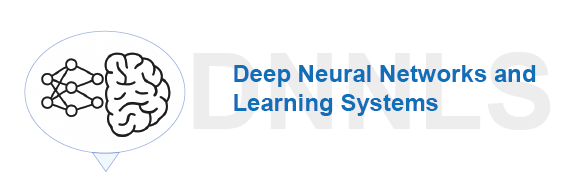

#  Experiment Notebook





In [1]:
!pip install transformers datasets

In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import math
def compute_bleu(reference_text: str, generated_text: str):
    smoothie = SmoothingFunction().method4

    # Tokenize by splitting on whitespace
    ref_tokens = reference_text.split()
    gen_tokens = generated_text.split()

    # Avoid BLEU errors with empty outputs
    if len(gen_tokens) == 0:
        return 0.0

    return sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothie)

def compute_perplexity(loss_value: float):
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float("inf")

In [3]:
# @title Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive
import os

from datasets import load_dataset

from datasets.fingerprint import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from transformers import BertTokenizer
import gc

import textwrap


# **Chapter 1: The data preparation**


---



## 1.1 Loading and saving data

In [4]:
# @title Setting up google drive to save checkpoints

# This will prompt you to authorize Google Drive access
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss


Mounted at /content/gdrive


In [5]:
# @title Functions to load images and process data


# This function just extracts the tags from the text, don't get distracted by it.
# I changed this function a bit to fix some bugs
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements using BeautifulSoup directly
        objects = [obj.get_text().strip() for obj in gdi.find_all('gdo')]
        actions = [act.get_text().strip() for act in gdi.find_all('gda')]
        locations = [loc.get_text().strip() for loc in gdi.find_all('gdl')]

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images

# This is an utility function to show images.
# Why do we need to do all this?
def show_image(ax, image, de_normalize = False, img_mean = None, img_std = None):
  """
  De-normalize the image (if necessary) and show image
  """
  if de_normalize:
    new_mean = -img_mean/img_std
    new_std = 1/img_std

    image = transforms.Normalize(
        mean=new_mean,
        std=new_std
    )(image)
  ax.imshow(image.permute(1, 2, 0))



Now we load dataset from HuggingFace:

In [6]:
# @title Loading the dataset
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

## 1.2 Three datasets



In [7]:
# @title Main dataset
class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer):
        super(SequencePredictionDataset, self).__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        # Potential experiments: Try other transforms!
        self.transform = transforms.Compose([
          transforms.Resize((60, 125)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      """
      Selects a 5 frame sequence from the dataset. Sets 4 for training and the last one
      as a target.
      """
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      frame_tensors = []
      description_list = []

      for frame_idx in range(4):
        image = FT.equalize(frames[frame_idx])
        input_frame = self.transform(image)
        frame_tensors.append(input_frame)

        # Potential experiments: Try using the other attributes in your training
        # objects = self.image_attributes[frame_idx]["objects"]
        # actions = self.image_attributes[frame_idx]["actions"]
        # locations = self.image_attributes[frame_idx]["locations"]

        description = self.image_attributes[frame_idx]["description"]
        # We need to return the tokens for NLP
        input_ids =  self.tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

        description_list.append(input_ids.squeeze(0))


      image_target = FT.equalize(frames[4])
      image_target = self.transform(image_target)
      text_target = self.image_attributes[4]["description"]

      target_ids = tokenizer(description,
                             return_tensors="pt",
                             padding="max_length",
                             truncation=True,
                             max_length=120).input_ids

      sequence_tensor = torch.stack(frame_tensors)  # shape: (num_frames, C, H, W)
      description_tensor = torch.stack(description_list) # (num_frames, max_length)

      return (sequence_tensor, # Returning the image
              description_tensor, # Returning the whole description
              image_target, # Image target
              target_ids) # Text target



In [8]:
# @title Text task dataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick
      frame_idx = np.random.randint(0, 5)
      description = self.image_attributes[frame_idx]["description"]

      return description  # Returning the whole description


In [9]:
# @title Dataset for image autoencoder task
class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.Resize((240, 500)),# Reasonable size based on our previous analysis
          transforms.ToTensor(), # HxWxC -> CxHxW
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the autoencoder

      return input_frame, # Returning the image

## 1.3 Creating and testing our dataset objects and loaders


---



In [10]:
# @title For the Sequence prediction task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
sp_train_dataset = SequencePredictionDataset(train_dataset, tokenizer) # Instantiate the train dataset
sp_test_dataset = SequencePredictionDataset(test_dataset, tokenizer) # Instantiate the test dataset

# Let's do things properly, we will also have a validation split
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(sp_train_dataset))
val_size = len(sp_train_dataset) - train_size
train_subset, val_subset = random_split(sp_train_dataset, [train_size, val_size])

# Instantiate the dataloaders
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
# We will use the validation set to visualize the progress.
val_dataloader = DataLoader(val_subset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(sp_test_dataset, batch_size=4, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# @title For the text task
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased",  padding=True, truncation=True)
text_dataset = TextTaskDataset(train_dataset)
text_dataloader = DataLoader(text_dataset, batch_size=4, shuffle=True)

In [12]:
# @title For the image autoencoder task
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=4, shuffle=True)

Description:  torch.Size([4, 120])
torch.Size([8, 4, 3, 60, 125])
torch.Size([8, 4, 120])


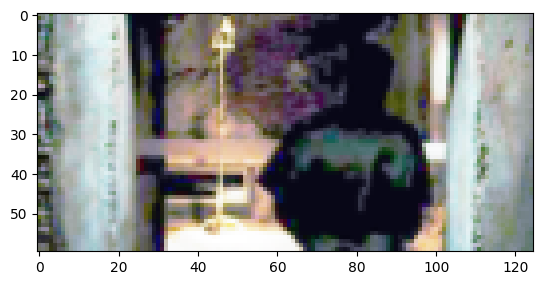

In [13]:
# @title Testing some of the outputs of the SP dataset
frames, descriptions, image_target, text_target = sp_train_dataset[np.random.randint(0,400)]

print("Description: ", descriptions.shape)
figure, ax = plt.subplots(1,1)
show_image(ax, image_target)

# Do some tests on the batches (try with batch size small)
frames, descriptions, image_target, text_target = next(iter(train_dataloader))
print(frames.shape)
print(descriptions.shape)

I will leave the test of the other datasets to you.

# **Chapter 2: Models**


---



## 2.1 The NLP models

In [14]:
# @title The text autoencoder (Seq2Seq)

class EncoderLSTM(nn.Module):
    """
      Encodes a sequence of tokens into a latent space representation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    """
      Decodes a latent space representation into a sequence of tokens.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_dim, vocab_size) # Should be hidden_dim

    def forward(self, input_seq, hidden, cell):
        embedded = self.embedding(input_seq)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

# We create the basic text autoencoder (a special case of a sequence to sequence model)
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, target_seq):
        # input_seq and target_seq are both your 'input_ids'
        # 1. Encode the input sequence
        _enc_out, hidden, cell = self.encoder(input_seq)

        # 2. Create the "shifted" decoder input for teacher forcing.
        # We want to predict target_seq[:, 1:]
        # So, we feed in target_seq[:, :-1]
        # (i.e., feed "[SOS], hello, world" to predict "hello, world, [EOS]")
        decoder_input = target_seq[:, :-1]

        # 3. Run the decoder *once* on the entire sequence.
        # It takes the encoder's final state (hidden, cell)
        # and the full "teacher" sequence (decoder_input).
        predictions, _hidden, _cell = self.decoder(decoder_input, hidden, cell)

        # predictions shape will be (batch_size, seq_len-1, vocab_size)
        return predictions


In [15]:
# @title Utility functions for NLP tasks
def generate(model, hidden, cell, max_len, sos_token_id, eos_token_id):
      """
        This function generates a sequence of tokens using the provided decoder.
      """
      # Ensure the model is in evaluation mode
      model.eval()

      # 2. SETUP DECODER INPUT
      # Start with the SOS token, shape (1, 1)
      dec_input = torch.tensor([[sos_token_id]], dtype=torch.long, device=device)
      # hidden = torch.zeros(1, 1, hidden_dim, device=device)
      # cell = torch.zeros(1, 1, hidden_dim, device=device)

      generated_tokens = []

      # 3. AUTOREGRESSIVE LOOP
      for _ in range(max_len):
          with torch.no_grad():
              # Run the decoder one step at a time
              # dec_input is (1, 1) here—it's just the last predicted token
              prediction, hidden, cell = model(dec_input, hidden, cell)

          logits = prediction.squeeze(1) # Shape (1, vocab_size)
          temperature = 0.9 # <--- Try a value between 0.5 and 1.0

          # 1. Divide logits by temperature
          # 2. Apply softmax to get probabilities
          # 3. Use multinomial to sample one token based on the probabilities
          probabilities = torch.softmax(logits / temperature, dim=-1)
          next_token = torch.multinomial(probabilities, num_samples=1)

          token_id = next_token.squeeze().item()

          # Check for the End-of-Sequence token
          if token_id == eos_token_id:
              break

          if token_id == 0 or token_id == sos_token_id:
              continue

            # Append the predicted token
          generated_tokens.append(token_id)

          # The predicted token becomes the input for the next iteration
          dec_input = next_token

      # Return the list of generated token IDs
      return generated_tokens


In [ ]:
# @title Do some tests
desc = text_dataset[np.random.randint(0, 100)]
print(f"Input: {desc}")
# input_ids = tokenizer(desc, return_tensors="pt",  padding=True, truncation=True).input_ids
# input_ids = input_ids.to(device)
# generated_tokens = generate(model, hidden, cell, max_len=100, sos_token_id=tokenizer.cls_token_id, eos_token_id=tokenizer.sep_token_id)
# print("Output: ", tokenizer.decode(generated_tokens))

Input: In the forest at night, Oliver lay hidden behind a tree, his heart pounding with fear. The dark and shadowy atmosphere made it hard for him to see, but Oliver could feel that he was being watched. Every sound made his skin crawl, and he couldn't help but wonder what dangers lurked in the darkness. The intense lighting only added to his sense of unease, making him feel like he was trapped in a nightmare. The couch in the background seemed out of place, a strange reminder of a world Oliver had left behind.


## 2.2 The Vision models

In [16]:
# @title The visual autoencoder
class Backbone(nn.Module):
    """
      Main convolutional blocks for our CNN
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(Backbone, self).__init__()
        # Encoder convolutional layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=2, padding=3),
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, 5, stride=2, padding=2),
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )

        # Calculate flattened dimension for linear layer
        self.flatten_dim = 64 * output_w * output_h
        # Latent space layers
        self.fc1 = nn.Sequential(nn.Linear(self.flatten_dim, latent_dim), nn.ReLU())


    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, self.flatten_dim)  # flatten for linear layer
        z = self.fc1(x)
        return z

class VisualEncoder(nn.Module):
    """
      Encodes an image into a latent space representation. Note the two pathways
      to try to disentangle the mean pattern from the image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualEncoder, self).__init__()

        self.context_backbone = Backbone(latent_dim, output_w, output_h)
        self.content_backbone = Backbone(latent_dim, output_w, output_h)

        self.projection = nn.Linear(2*latent_dim, latent_dim)
    def forward(self, x):
        z_context = self.context_backbone(x)
        z_content = self.content_backbone(x)
        z = torch.cat((z_content, z_context), dim=1)
        z = self.projection(z)
        return z

class VisualDecoder(nn.Module):
    """
      Decodes a latent representation into a content image and a context image
    """
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualDecoder, self).__init__()
        self.imh = 60
        self.imw = 125
        self.flatten_dim = 64 * output_w * output_h
        self.output_w = output_w
        self.output_h = output_h

        self.fc1 = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
          nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
          nn.GroupNorm(8, 32),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
          nn.GroupNorm(8, 16),
          nn.LeakyReLU(0.1),

          nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=(1, 1)),
          nn.Sigmoid() # Use nn.Tanh() if your data is normalized to [-1, 1]
      )

    def forward(self, z):
      x = self.fc1(z)

      x_content = self.decode_image(x)
      x_context = self.decode_image(x)

      return x_content, x_context

    def decode_image(self, x):
      x = x.view(-1, 64, self.output_w, self.output_h)      # reshape to conv feature map
      x = self.decoder_conv(x)
      x = x[:, :, :self.imh, :self.imw]          # crop to original size if needed
      return x

class VisualAutoencoder( nn.Module):
    def __init__(self, latent_dim=16, output_w = 8, output_h = 16):
        super(VisualAutoencoder, self).__init__()
        self.encoder = VisualEncoder(latent_dim, output_w, output_h)
        self.decoder = VisualDecoder(latent_dim, output_w, output_h)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat



## 2.3 The main architecture


In [17]:
# @title A simple attention architecture

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        # This "attention" layer learns a query vector
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1) # Over the sequence length

    def forward(self, rnn_outputs):
        # rnn_outputs shape: [batch, seq_len, hidden_dim]

        # Pass through linear layer to get "energy" scores
        energy = self.attn(rnn_outputs).squeeze(2) # Shape: [batch, seq_len]

        # Get attention weights
        attn_weights = self.softmax(energy) # Shape: [batch, seq_len]

        # Apply weights
        # attn_weights.unsqueeze(1) -> [batch, 1, seq_len]
        # bmm with rnn_outputs -> [batch, 1, hidden_dim]
        context = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs)

        # Squeeze to get final context vector
        return context.squeeze(1) # Shape: [batch, hidden_dim]

In [18]:
class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder, latent_dim,
                 gru_hidden_size): # Renamed gru_hidden_dim to gru_hidden_size for clarity
        super(SequencePredictor, self).__init__()

        # --- 1. Static Encoders ---
        # (These process one pair at a time)
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder = text_autoencoder.encoder

        # --- 2. Temporal Encoder ---
        # (This processes the sequence of pairs)
        fusion_dim = latent_dim * 2 # z_visual + z_text
        self.temporal_rnn = nn.GRU(fusion_dim, gru_hidden_size, batch_first=True, bidirectional=True) # Changed to unidirectional

        # The actual output dimension of the unidirectional GRU
        self.gru_output_dim = gru_hidden_size *2  # Changed for unidirectional

        # --- 3. Attention ---
        self.attention = Attention(self.gru_output_dim)

        # --- 4. Final Projection ---
        # Input to projection will be concatenated h_combined and context
        # h_combined (from GRU's h) will be gru_output_dim
        # context (from attention) will be gru_output_dim
        # So, input to projection is gru_output_dim * 2
        self.projection = nn.Sequential(
            nn.Linear(self.gru_output_dim * 2, latent_dim), # Corrected input size for unidirectional
            nn.ReLU()
        )

        # --- 5. Decoders ---
        # (These predict the *next* item)
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder = text_autoencoder.decoder

        # The hidden and cell states for text_decoder should match its own latent_dim
        # The text_decoder's LSTM is initialized with hidden_dim=latent_dim
        self.fused_to_h0 = nn.Linear(latent_dim, latent_dim) # Project to text_decoder's hidden_dim
        self.fused_to_c0 = nn.Linear(latent_dim, latent_dim) # Project to text_decoder's hidden_dim

    def forward(self, image_seq, text_seq, target_seq):
        # image_seq shape: [batch, seq_len, C, H, W]
        # text_seq shape:  [batch, seq_len, text_len]
        # target_text_for_teacher_forcing: [batch, 1, text_len]

        batch_size, seq_len, C, H, W = image_seq.shape

        # --- 1 & 2: Run Static Encoders over the sequence ---
        # We can't pass a 5D/4D tensor to the encoders.
        # We "flatten" the batch and sequence dimensions.

        # Reshape for image_encoder
        img_flat = image_seq.view(batch_size * seq_len, C, H, W)
        # Reshape for text_encoder
        txt_flat = text_seq.view(batch_size * seq_len, -1) # -1 infers text_len

        # Run encoders
        z_v_flat = self.image_encoder(img_flat) # Shape: [b*s, latent]
        _, hidden_txt, cell_txt = self.text_encoder(txt_flat) # Renamed hidden, cell to hidden_txt, cell_txt for clarity

        # Combine visual latent and text encoder's final hidden state
        # text_encoder's hidden output is [num_layers, b*s, latent_dim]
        # Assuming num_layers=1, this is [1, b*s, latent_dim]
        # Squeeze 0 to get [b*s, latent_dim]
        z_fusion_flat = torch.cat((z_v_flat, hidden_txt.squeeze(0)), dim=1) # Shape: [b*s, fusion_dim]

        # "Un-flatten" back into a sequence
        z_fusion_seq = z_fusion_flat.view(batch_size, seq_len, -1) # Shape: [b, s, fusion_dim]

        # --- 3. Run Temporal Encoder ---
        zseq, h = self.temporal_rnn(z_fusion_seq)
        # zseq shape: [batch, seq_len, gru_hidden_size]
        # h shape: [num_layers, batch, gru_hidden_size] -> [1, batch, gru_hidden_size] for num_layers=1

        # For unidirectional GRU, h_combined is simply the squeezed hidden state
        #h_combined = h.squeeze(0) # Shape: [batch, gru_hidden_size]
        h = h.view(1, 2, batch_size, -1)  # → [1, 2, B, hidden]

        h_forward = h[0, 0]     # [B, hidden]
        h_backward = h[0, 1]    # [B, hidden]

        # Combine both directions → [B, hidden*2]
        h_combined = torch.cat((h_forward, h_backward), dim=-1)

        # --- 4. Attention ---
        context = self.attention(zseq) # Shape: [b, gru_hidden_size]

        # --- 5. Final Prediction Vector (z) ---
        # Concatenate h_combined and context
        z = self.projection(torch.cat((h_combined, context), dim=1)) # Input to projection is [batch, 2 * gru_hidden_size]

        # --- 6. Decode (Predict pk) ---
        pred_image_content, pred_image_context = self.image_decoder(z)

        # The initial hidden and cell states for the text decoder
        h0 = self.fused_to_h0(z).unsqueeze(0) # z is [batch, latent_dim], h0 becomes [1, batch, latent_dim]
        c0 = self.fused_to_c0(z).unsqueeze(0) # c0 becomes [1, batch, latent_dim]

        # text_decoder expects input_seq, hidden, cell
        # target_seq has shape [batch, 1, 120]
        # decoder_input should be [batch_size, 119] for text_decoder's forward
        decoder_input = target_seq.squeeze(1)[:, :-1] # Corrected: target_seq is [batch, 1, 120] -> squeeze(1) -> [batch, 120] -> [:, :-1] -> [batch, 119]

        predicted_text_logits_k, _hidden, _cell = self.text_decoder(decoder_input, h0, c0)

        return pred_image_content, pred_image_context, predicted_text_logits_k, h0, c0

# **Chapter 3: Training routines**


---




In [19]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(m.bias, 0)

In [20]:
def validation( model, data_loader ):
  model.eval()
  with torch.no_grad():
    frames, descriptions, image_target, text_target = next(iter(data_loader))

    descriptions = descriptions.to(device)
    frames = frames.to(device)
    image_target = image_target.to(device)
    text_target = text_target.to(device)

    # Get all predictions from the model's forward pass
    pred_image_content, pred_image_context, predicted_text_logits_k, hidden, cell = model(frames, descriptions, text_target)

    # Calculate text loss using predicted_text_logits_k and text_target, similar to the training loop
    prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
    target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [batch, 119]
    target_flat = target_labels.reshape(-1)
    ce_loss = criterion_text(prediction_flat, target_flat).item()
    ppl = compute_perplexity(ce_loss)
    #print("Perplexity:", ppl)

    figure, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={'height_ratios': [2, 1.5]})

    for i in range(4):
      im = frames[0, i, :, :, :].cpu()
      show_image(ax[0,i], im )
      ax[0,i].set_aspect('auto')
      ax[0,i].axis('off')
      wrapped_text = textwrap.fill(tokenizer.decode(descriptions[0, i, :], skip_special_tokens=True), width=40)

      ax[1,i].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=True
        )

      ax[1,i].axis('off') # Hide axes for the text subplot

    show_image(ax[0,4], image_target[0].cpu())
    ax[0,4].set_title('Target')
    ax[0,4].set_aspect('auto')
    ax[0,4].axis('off')
    text_target_for_decode = text_target.squeeze(1)

    wrapped_text = textwrap.fill(tokenizer.decode(text_target_for_decode[0], skip_special_tokens=True), width=40)
    ax[1,4].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False)
    ax[1,4].axis('off')
    output = pred_image_context[0, :, :, :].cpu() # Use predicted context image for visualization
    show_image(ax[0,5], output)
    ax[0,5].set_title('Predicted')
    ax[0,5].set_aspect('auto')
    ax[0,5].axis('off')

    generated_tokens = generate(model.text_decoder,
                                hidden[:,0, :].unsqueeze(1),
                                cell[:, 0, :].unsqueeze(1),
                                max_len=150,
                                sos_token_id=tokenizer.cls_token_id,
                                eos_token_id=tokenizer.sep_token_id)

    wrapped_text = textwrap.fill(tokenizer.decode(generated_tokens), width=40)

    # Pass strings to compute_bleu, not pre-tokenized lists
    ref_text_for_bleu = tokenizer.decode(text_target_for_decode[0], skip_special_tokens=True)
    pred_text_for_bleu = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    bleu = compute_bleu(ref_text_for_bleu, pred_text_for_bleu)
    #print("BLEU-4:", bleu)

    ax[1,5].text(
            0.5, 0.99,
            wrapped_text,
            ha='center',
            va='top',
            fontsize=10,
            wrap=False )
    ax[1,5].axis('off')
    plt.tight_layout()
    plt.show()
    return bleu, ppl

## 3.1 Initialization and setup

In [21]:
# @title Variables and initial setup
torch.cuda.empty_cache()
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_EPOCHS = 5
emb_dim = 16
latent_dim = 16
num_layers = 1
dropout = True

In [22]:
# @title Initializing the NLP models
encoder = EncoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
decoder = DecoderLSTM(tokenizer.vocab_size, emb_dim, latent_dim, num_layers, dropout).to(device)
text_autoencoder = Seq2SeqLSTM(encoder, decoder).to(device)
text_autoencoder, _, _, _ = load_checkpoint_from_drive(text_autoencoder, None, filename='text_autoencoder.pth')

total_params = sum(p.numel() for p in text_autoencoder.parameters())
print(f"Total parameters (Not trainable): {total_params}")
# Deactivating training from this model for efficiency (although not ideal)
for param in text_autoencoder.parameters():
        param.requires_grad = False


Checkpoint loaded from: /content/gdrive/MyDrive/DL_Checkpoints/text_autoencoder.pth (epoch 15)
Total parameters (Not trainable): 1499930


In [23]:
# @title Initializing visual models
visual_autoencoder = VisualAutoencoder(latent_dim=16)
visual_autoencoder.apply(init_weights)

total_params = sum(p.numel() for p in visual_autoencoder.parameters() if p.requires_grad)
print(f"Total trainable parameters in visual autoencoder: {total_params}")

Total trainable parameters in visual autoencoder: 503539


In [24]:
# @title Initialize the main architecture
# We put all the sizes the same, not ideal as well
sequence_predictor = SequencePredictor(visual_autoencoder, text_autoencoder, latent_dim, latent_dim) # gru_hidden_size is latent_dim (16)
sequence_predictor.to(device)

# # Print number of trainable parameters
total_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print(f"Total trainable parameters in the whole model: {total_params}")

# Print model size
total_params = sum(p.numel() for p in sequence_predictor.parameters())
print(f"Total parameters: {total_params}")


Total trainable parameters in the whole model: 509956
Total parameters: 2009886


## 3.2 Training loops

In [25]:
# @title Training tools
criterion_images = nn.L1Loss()
criterion_ctx = nn.MSELoss()
criterion_text = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids(tokenizer.pad_token))
optimizer = torch.optim.Adam(sequence_predictor.parameters(), lr=0.001)

In [29]:
# @title Training loop for the sequence predictor
# Instantiate the model, define loss and optimizer

sequence_predictor.train()
losses = []
metrics = []
for epoch in range(N_EPOCHS):


    running_loss = 0.0
    for frames, descriptions, image_target, text_target  in train_dataloader:

      # Send images and tokens to the GPU
      descriptions = descriptions.to(device)
      frames = frames.to(device)
      image_target = image_target.to(device)
      text_target = text_target.to(device)
      # Predictions from our model
      pred_image_content, pred_image_context, predicted_text_logits_k, _, _ = sequence_predictor(frames, descriptions, text_target)
      # Computing losses
      # Loss for image reconstruction
      loss_im = criterion_images(pred_image_content, image_target)
      # Loss for the average pattern the images contain
      mu_global = frames.mean(dim=[0, 1])
      mu_global = mu_global.unsqueeze(0).expand_as(pred_image_context)
      loss_context = criterion_ctx(pred_image_context, mu_global)
      # Loss function for the text prediction
      prediction_flat = predicted_text_logits_k.reshape(-1, tokenizer.vocab_size)
      target_labels = text_target.squeeze(1)[:, 1:] # Slice to get [8, 119]
      target_flat = target_labels.reshape(-1)
      loss_text = criterion_text(prediction_flat, target_flat)
      # Combining the losses
      loss = loss_im + loss_text + 0.2*loss_context
      # Optimizing
      optimizer.zero_grad()
      loss.backward() # Corrected: Removed accidental '+'
      optimizer.step()

      running_loss += loss.item() * frames.size(0)

    # checking model performance on validation set
    sequence_predictor.eval()
    print("Validation on training dataset")
    print( "----------------")
    train_bleu, train_ppl = validation( sequence_predictor, train_dataloader )
    print("Validation on validation dataset")
    print( "----------------")
    val_bleu, val_ppl = validation( sequence_predictor, val_dataloader)
    sequence_predictor.train()

    # scheduler.step()
    epoch_loss = running_loss / len(train_dataloader.dataset)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Loss: {epoch_loss:.4f}')
    print(f'Train BLEU: {train_bleu:.4f}, Train PPL: {train_ppl:.4f},' f'Val BLEU: {val_bleu:.4f}, Val PPL: {val_ppl:.4f}')
    # ★ ADD: Save epoch metrics to table
    metrics.append({
    "epoch": epoch+1,
    "loss": epoch_loss,
    "train_bleu": train_bleu,
    "train_ppl": train_ppl,
    "val_bleu": val_bleu,
    "val_ppl": val_ppl
})



    if epoch % 5 == 0:
      save_checkpoint_to_drive(sequence_predictor, optimizer, epoch, epoch_loss, filename=f"sequence_predictor.pth")

# Do better plots
results_df = pd.DataFrame(metrics)
print(results_df)
# ★ ADD: Improved Training Plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Loss Plot
ax[0].plot(results_df["epoch"], results_df["loss"], marker="o")
ax[0].set_title("Training Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

# BLEU Plot
ax[1].plot(results_df["epoch"], results_df["train_bleu"], marker="o", color="green", label="Train BLEU")
ax[1].plot(results_df["epoch"], results_df["val_bleu"], marker="o", color="orange", label="Val BLEU")
ax[1].set_title("BLEU Score per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("BLEU")
ax[1].legend()
ax[1].grid(True)

# Perplexity Plot
ax[2].plot(results_df["epoch"], results_df["train_ppl"], marker="o", color="purple", label="Train PPL")
ax[2].plot(results_df["epoch"], results_df["val_ppl"], marker="o", color="red", label="Val PPL")
ax[2].set_title("Perplexity per Epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("PPL")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()



Output hidden; open in https://colab.research.google.com to view.